In [ ]:
import warnings
warnings.filterwarnings('ignore')

### 1. Importar Librerias

In [ ]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from bayes_opt import BayesianOptimization
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.linear_model import LogisticRegression
import pickle
import xgboost as xgb
from sklearn.ensemble import BaggingClassifier

### 2. Cargar Conjunto de Datos

In [ ]:
# Carga de archivos parquet
df_train = pd.read_parquet("df_train.parquet")
df_test = pd.read_parquet("df_test.parquet")

### 3. EDA

In [ ]:
# Identificar la estructura del conjunto de datos de entrenamiento
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160396 entries, 126581 to 224138
Data columns (total 83 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   GENERO                                      160396 non-null  object 
 1   ESTADO_CIVIL                                160396 non-null  object 
 2   EDAD                                        160396 non-null  float64
 3   GRUPO_ETAREO                                160396 non-null  object 
 4   TipoAfiliado                                160392 non-null  object 
 5   Estrato                                     160396 non-null  object 
 6   TSISTOLICA                                  135371 non-null  object 
 7   TDIASTOLICA                                 135306 non-null  object 
 8   ANTIHIPERTENSIVOS                           160396 non-null  object 
 9   AEI                                         160396 non-null  obje

In [ ]:
# An[alisis descriptivo estadistico de las varianles del dataset
df_train.describe()

,EDAD,CMes_6,CMes_5,CMes_4,CMes_3,CMes_2,CMes_1,SMes_6,SMes_5,SMes_4,...,Target,RIESGOS,IV_NIVEL,HOSPI_NO_QUIRURGICA,CANTIDAD_URGENCIAS,HOSPITALIZACION,SERVICIOS,MEDICAMENTOS,Antiguedad_paciente,Tiempo_Ultima_cita
count,160396.000000,1.603960e+05,1.603960e+05,1.603960e+05,1.603960e+05,1.603960e+05,1.603960e+05,160396.000000,160396.000000,160396.000000,...,160396.000000,160396.000000,160396.000000,160396.000000,160396.000000,160396.000000,160396.000000,160396.000000,160396.000000,160396.000000
mean,64.633638,3.676481e+04,3.675277e+04,3.538102e+04,3.952722e+04,4.239327e+04,4.501093e+04,0.062389,0.063293,0.069615,...,0.042582,1.671525,0.004670,0.009813,0.032538,0.014707,0.425896,4.961620,10.846517,18.155484
std,13.722636,1.703080e+05,1.744866e+05,1.664544e+05,1.699679e+05,1.821380e+05,1.937191e+05,0.779170,0.647437,0.758565,...,0.201914,1.090391,0.211687,0.114982,0.197070,0.241960,3.060843,4.693764,7.816486,24.372321
min,2.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.834360,-0.082136
25%,56.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.915127,0.887064
50%,65.000000,1.320000e+03,1.440000e+03,1.710000e+03,2.430000e+03,2.460000e+03,2.430000e+03,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,8.914442,1.215606
75%,74.000000,1.017000e+04,1.035000e+04,1.045500e+04,1.311000e+04,1.422000e+04,1.458000e+04,0.000000,0.000000,0.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,17.768652,52.914442
max,107.000000,5.822942e+06,5.735720e+06,5.874878e+06,5.815378e+06,5.744101e+06,5.949703e+06,123.000000,40.000000,48.000000,...,1.000000,11.000000,14.000000,6.000000,6.000000,14.000000,194.000000,59.000000,27.586585,52.914442


In [ ]:
# Convertir celdas con valores faltantes en valores nulos
df_train = df_train.replace(" ?", np.NaN)
# Cambiar el tipo de las variables 'TSISTOLICA' y 'TDIASTOLICA' por punto flotante
df_train['TSISTOLICA'] = df_train['TSISTOLICA'].astype(float)
df_train['TDIASTOLICA'] = df_train['TDIASTOLICA'].astype(float)


In [ ]:
# eliminar filas del DataFrame df_train donde el valor en la columna "Target" es nulo (NaN).
df_train= df_train.dropna(subset=["Target"])

### 4. Analisis de Baseline

In [ ]:
## Analisis de balanceo de Variable Objetivo

In [ ]:
df_train.Target.value_counts(True)

0    0.957418
1    0.042582
Name: Target, dtype: float64

In [ ]:
# Funcion de Transformaciones aplicada a df

def Transformaciones(df):
    import numpy as np
    import pandas as pd

    # Reemplazar " ?" con NaN
    df = df.replace(" ?", np.NaN)
    df['TSISTOLICA'] = df['TSISTOLICA'].astype(float)
    df['TDIASTOLICA'] = df['TDIASTOLICA'].astype(float)

    # Análisis con clasificacion de missing values segun porcentaje
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    missing_values_percentage = (missing_values / len(df)) * 100

    # Eliminar columnas con más del 80% de valores faltantes
    cols_to_drop = missing_values[missing_values_percentage > 80].index
    df_cleaned = df.drop(columns=cols_to_drop)

    df_winsorized = df_cleaned.copy()

    # Verificar si la columna "Target" existe
    if "Target" in df_winsorized.columns:
        X, y = df_winsorized.drop(columns="Target"), df_winsorized["Target"]
    else:
        X = df_winsorized

    # Manejo de outliers con Winsorización basada en el método Inter Quartile Range IQR
    numeric_cols = X.select_dtypes(include=['float64', 'int64'])

    # Definir cuartil 1, cuartil 3 y rango intercuartilico
    for col in numeric_cols:
        Q1 = X[col].quantile(0.25)
        Q3 = X[col].quantile(0.75)
        IQR = Q3 - Q1
    # identificar  valores atipicos (outliers)  inferiores (lower: por debajo de Q1 - 1.5 * IQR); y superiores (Upper por encima de Q3 + 1.5 * IQR)
        lower_outliers = X[col] < (Q1 - 1.5 * IQR)
        upper_outliers = X[col] > (Q3 + 1.5 * IQR)

        X.loc[lower_outliers, col] = Q1
        X.loc[upper_outliers, col] = Q3

    # Definir el mapeo de valores para convetir la variable categorica 'GRUPO_ETAREO' a numerica
    grupo_etareo_mapping = {
        '1 a 4 años': 0.1,
        '5 a 14 años': 0.2,
        '15 a 18 años': 0.3,
        '19 a 44 años': 0.4,
        '45 a 49 años': 0.5,
        '50 a 54 años': 0.6,
        '55 a 59 años': 0.7,
        '60 a 64 años': 0.8,
        '65 a 69 años': 0.9,
        '70 a 74 años': 1.0,
        '75 años y más': 1.1
    }

    # Reemplazar los valores en la columna GRUPO_ETAREO
    if 'GRUPO_ETAREO' in X.columns:
        X['GRUPO_ETAREO'] = X['GRUPO_ETAREO'].replace(grupo_etareo_mapping)

    # Eliminar columnas adicionales mencionadas
    cols_to_drop_additional = ["EXFUMADOR", "FECHA_ALBUMINURIA_LAB", "FECHA_CERO", "FECHA_COLESTEROL_TOTAL_LAB",
                               "FECHA_CREATININA_EN_SUERO_ORINA_OTROS_LAB", "FECHA_HDL_LAB", "FECHA_HEMOGLOBINA_GLICOSILADA_LAB",
                               "FECHA_HEMOGLOBINA_LAB", "FECHA_LDL_LAB", "FECHA_RELACION_ALBUMINURIA_CREATINURIA_LAB",
                               "FECHA_TRIGLICERIDOS_LAB", "FECHA_ULTIMA_CITA", "FECHA_UROANALISIS_LAB", "FUMADOR"]
    X = X.drop(columns=[col for col in cols_to_drop_additional if col in X.columns])

    if "Target" in df_winsorized.columns:
        return X, y
    else:
        return X




### 4. Missing Values

In [ ]:
# Análisis de missing values
missing_values = df_train.isnull().sum()

# Filtramos solo las columnas que tienen valores faltantes
missing_values = missing_values[missing_values > 0]

missing_values_percentage = (missing_values / len(df_train)) * 100
missing_values_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_values_percentage
})

missing_values_df.sort_values(by='Percentage (%)', ascending=False)



,Missing Values,Percentage (%)
FECHA_ALBUMINURIA24_LAB,154407,96.266116
ALBUMINURIA24,154407,96.266116
FECHA_CREATININA_24_LAB,150398,93.766677
CREATININA_24,150398,93.766677
FECHA_PROTEINURIA_LAB,145215,90.535300
PROTEINURIA,145215,90.535300
FECHA_CREATININA_DEPURACION_LAB,144060,89.815207
CREATININA_DEPURACION,144060,89.815207
PTH,142021,88.543979
FECHA_PTH_LAB,142021,88.543979


In [ ]:
# 1. Eliminar columnas con más del 80% de valores faltantes
cols_to_drop = missing_values_df[missing_values_df['Percentage (%)'] > 80].index
train_data_cleaned = df_train.drop(columns=cols_to_drop)



In [ ]:
train_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160396 entries, 126581 to 224138
Data columns (total 69 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   GENERO                                      160396 non-null  object 
 1   ESTADO_CIVIL                                160396 non-null  object 
 2   EDAD                                        160396 non-null  float64
 3   GRUPO_ETAREO                                160396 non-null  object 
 4   TipoAfiliado                                160392 non-null  object 
 5   Estrato                                     160396 non-null  object 
 6   TSISTOLICA                                  135371 non-null  float64
 7   TDIASTOLICA                                 135306 non-null  float64
 8   ANTIHIPERTENSIVOS                           160396 non-null  object 
 9   AEI                                         160396 non-null  obje

### 5. Outliers (IQR)

In [ ]:
train_data_winsorized = train_data_cleaned.copy()


In [ ]:
X, y = train_data_winsorized.drop(columns="Target"), train_data_winsorized["Target"]

In [ ]:
# Identificación de outliers usando el método IQR
outliers_dict = {}

# Seleccionamos solo columnas numéricas
numeric_cols = X.select_dtypes(include=['float64', 'int64'])

for col in numeric_cols:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = X[(X[col] < (Q1 - 1.5 * IQR)) | (X[col] > (Q3 + 1.5 * IQR))]

    # Almacenamos la cantidad y porcentaje de outliers por columna
    outliers_dict[col] = [len(outliers), len(outliers) / len(X) * 100]

# Convertimos el diccionario a DataFrame
outliers_df = pd.DataFrame.from_dict(outliers_dict, orient='index', columns=['Outliers Count', 'Percentage (%)']).sort_values(by='Percentage (%)', ascending=False)

outliers_df


,Outliers Count,Percentage (%)
CMes_1,28422,17.719893
CMes_2,28237,17.604554
CMes_4,27646,17.236091
CMes_3,27611,17.214270
CMes_5,27292,17.015387
CMes_6,26981,16.821492
SERVICIOS,21605,13.469787
TSISTOLICA,15323,9.553231
MMes_3,11427,7.124242
MMes_1,10958,6.831841


In [ ]:
# Winsorización basada en el método IQR
winsorized_dict = {}

# Seleccionamos solo columnas numéricas
numeric_cols = X.select_dtypes(include=['float64', 'int64'])

for col in numeric_cols:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1

    # Identifica los registros que serán truncados
    lower_outliers = X[col] < (Q1 - 1.5 * IQR)
    upper_outliers = X[col] > (Q3 + 1.5 * IQR)

    # Aplica la truncación
    X.loc[lower_outliers, col] = Q1
    X.loc[upper_outliers, col] = Q3

    # Almacenamos la cantidad y porcentaje de valores realmente modificados por columna
    winsorized_count = lower_outliers.sum() + upper_outliers.sum()
    winsorized_dict[col] = [winsorized_count, winsorized_count / len(X) * 100]

# Convertimos el diccionario a DataFrame
winsorized_df = pd.DataFrame.from_dict(winsorized_dict, orient='index', columns=['Winsorized Count', 'Percentage (%)']).sort_values(by='Percentage (%)', ascending=False)

winsorized_df


,Winsorized Count,Percentage (%)
CMes_1,28422,17.719893
CMes_2,28237,17.604554
CMes_4,27646,17.236091
CMes_3,27611,17.214270
CMes_5,27292,17.015387
CMes_6,26981,16.821492
SERVICIOS,21605,13.469787
TSISTOLICA,15323,9.553231
MMes_3,11427,7.124242
MMes_1,10958,6.831841


In [ ]:
# Identificación de outliers usando el método IQR
outliers_dict = {}

# Seleccionamos solo columnas numéricas
numeric_cols = X.select_dtypes(include=['float64', 'int64'])

for col in numeric_cols:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = X[(X[col] < (Q1 - 1.5 * IQR)) | (X[col] > (Q3 + 1.5 * IQR))]

    # Almacenamos la cantidad y porcentaje de outliers por columna
    outliers_dict[col] = [len(outliers), len(outliers) / len(X) * 100]

# Convertimos el diccionario a DataFrame
outliers_df = pd.DataFrame.from_dict(outliers_dict, orient='index', columns=['Outliers Count', 'Percentage (%)']).sort_values(by='Percentage (%)', ascending=False)

outliers_df


,Outliers Count,Percentage (%)
EDAD,0,0.0
TSISTOLICA,0,0.0
Antiguedad_paciente,0,0.0
MEDICAMENTOS,0,0.0
SERVICIOS,0,0.0
HOSPITALIZACION,0,0.0
CANTIDAD_URGENCIAS,0,0.0
HOSPI_NO_QUIRURGICA,0,0.0
IV_NIVEL,0,0.0
RIESGOS,0,0.0


In [ ]:
X.describe()

,EDAD,TSISTOLICA,TDIASTOLICA,CMes_6,CMes_5,CMes_4,CMes_3,CMes_2,CMes_1,SMes_6,...,MMes_1,RIESGOS,IV_NIVEL,HOSPI_NO_QUIRURGICA,CANTIDAD_URGENCIAS,HOSPITALIZACION,SERVICIOS,MEDICAMENTOS,Antiguedad_paciente,Tiempo_Ultima_cita
count,160396.000000,135371.000000,135306.000000,160396.000000,160396.000000,160396.000000,160396.000000,160396.000000,160396.000000,160396.0,...,160396.000000,160396.000000,160396.0,160396.0,160396.0,160396.0,160396.0,160396.000000,160396.000000,160396.000000
mean,64.862933,124.333535,76.867574,4208.855021,4296.555213,4356.658788,5549.206003,5930.949163,6059.740866,0.0,...,0.697019,1.515586,0.0,0.0,0.0,0.0,0.0,4.633270,10.846517,18.155484
std,13.254945,8.392915,7.471537,5366.250240,5408.514821,5433.477126,6875.755331,7421.049490,7608.530007,0.0,...,0.688249,0.805364,0.0,0.0,0.0,0.0,0.0,3.975212,7.816486,24.372321
min,29.000000,105.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,-1.834360,-0.082136
25%,56.000000,120.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,3.915127,0.887064
50%,65.000000,120.000000,80.000000,1320.000000,1440.000000,1710.000000,2430.000000,2460.000000,2430.000000,0.0,...,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,4.000000,8.914442,1.215606
75%,74.000000,130.000000,80.000000,10170.000000,10350.000000,10455.000000,13110.000000,14220.000000,14580.000000,0.0,...,1.000000,2.000000,0.0,0.0,0.0,0.0,0.0,7.000000,17.768652,52.914442
max,101.000000,145.000000,95.000000,25424.000000,25875.000000,26136.000000,32768.000000,35550.000000,36450.000000,0.0,...,2.000000,3.000000,0.0,0.0,0.0,0.0,0.0,16.000000,27.586585,52.914442


### 6. Particionamiento y Balanceo

In [ ]:
y.value_counts(True) * 100

0    95.741789
1     4.258211
Name: Target, dtype: float64

In [ ]:
n=y.value_counts()[1]
n1=n*2
n2=n*8

In [ ]:
df1 = pd.concat([X,y], axis=1)

In [ ]:
print(df1['Target'].value_counts())
# base_dummys_temp=base_dummys[base_dummys['Target'] ==0].sample(n=22766, random_state=1)
df_temp=df1[df1['Target'] ==0].sample(n=n2, random_state=1)
df1=pd.concat([df_temp,df1[df1['Target'] ==1]], axis=0)
df_temp=df1[df1['Target'] ==1].sample(n=n, random_state=1,replace=True)
df1=pd.concat([df_temp,df1], axis=0)
print(df1['Target'].value_counts())
print(df1['Target'].value_counts(True))

0    153566
1      6830
Name: Target, dtype: int64
0    54640
1    13660
Name: Target, dtype: int64
0    0.8
1    0.2
Name: Target, dtype: float64


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68300 entries, 213116 to 52611
Data columns (total 69 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   GENERO                                      68300 non-null  object 
 1   ESTADO_CIVIL                                68300 non-null  object 
 2   EDAD                                        68300 non-null  float64
 3   GRUPO_ETAREO                                68300 non-null  object 
 4   TipoAfiliado                                68299 non-null  object 
 5   Estrato                                     68300 non-null  object 
 6   TSISTOLICA                                  58251 non-null  float64
 7   TDIASTOLICA                                 58229 non-null  float64
 8   ANTIHIPERTENSIVOS                           68300 non-null  object 
 9   AEI                                         68300 non-null  object 
 10  CANCE

In [ ]:
df2 = df1.drop(columns= ["Target","EXFUMADOR", "FECHA_ALBUMINURIA_LAB", "FECHA_CERO", "FECHA_COLESTEROL_TOTAL_LAB", "FECHA_CREATININA_EN_SUERO_ORINA_OTROS_LAB", "FECHA_HDL_LAB", "FECHA_HEMOGLOBINA_GLICOSILADA_LAB", "FECHA_HEMOGLOBINA_LAB", "FECHA_LDL_LAB", "FECHA_RELACION_ALBUMINURIA_CREATINURIA_LAB", "FECHA_TRIGLICERIDOS_LAB", "FECHA_ULTIMA_CITA", "FECHA_UROANALISIS_LAB", "FUMADOR"])

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68300 entries, 213116 to 52611
Data columns (total 54 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   GENERO                            68300 non-null  object 
 1   ESTADO_CIVIL                      68300 non-null  object 
 2   EDAD                              68300 non-null  float64
 3   GRUPO_ETAREO                      68300 non-null  object 
 4   TipoAfiliado                      68299 non-null  object 
 5   Estrato                           68300 non-null  object 
 6   TSISTOLICA                        58251 non-null  float64
 7   TDIASTOLICA                       58229 non-null  float64
 8   ANTIHIPERTENSIVOS                 68300 non-null  object 
 9   AEI                               68300 non-null  object 
 10  CANCER_MAMA_FAMILIAR              68300 non-null  object 
 11  CANCER_OTRO_SITIO_FAMILIAR        68300 non-null  object 
 12 

In [ ]:
distinct_grupo_etareo = df2[['GRUPO_ETAREO']].drop_duplicates().reset_index(drop=True)
distinct_grupo_etareo

,GRUPO_ETAREO
0,75 años y más
1,19 a 44 años
2,65 a 69 años
3,70 a 74 años
4,55 a 59 años
5,60 a 64 años
6,50 a 54 años
7,45 a 49 años
8,5 a 14 años
9,15 a 18 años


In [ ]:
distinct_grupo_etareo_test = df_test[['GRUPO_ETAREO']].drop_duplicates().reset_index(drop=True)
distinct_grupo_etareo_test

,GRUPO_ETAREO
0,65 a 69 años
1,50 a 54 años
2,60 a 64 años
3,55 a 59 años
4,70 a 74 años
5,75 años y más
6,19 a 44 años
7,45 a 49 años
8,15 a 18 años
9,5 a 14 años


In [ ]:
# Definir el mapeo de valores
grupo_etareo_mapping = {
    '1 a 4 años': 0.1,
    '5 a 14 años': 0.2,
    '15 a 18 años': 0.3,
    '19 a 44 años': 0.4,
    '45 a 49 años': 0.5,
    '50 a 54 años': 0.6,
    '55 a 59 años': 0.7,
    '60 a 64 años': 0.8,
    '65 a 69 años': 0.9,
    '70 a 74 años': 1.0,
    '75 años y más': 1.1
}

# Reemplazar los valores en la columna GRUPO_ETAREO
df2['GRUPO_ETAREO'] = df2['GRUPO_ETAREO'].replace(grupo_etareo_mapping)


In [ ]:
# Definir el mapeo de valores
grupo_etareo_mapping_test = {
    '1 a 4 años': 0.1,
    '5 a 14 años': 0.2,
    '15 a 18 años': 0.3,
    '19 a 44 años': 0.4,
    '45 a 49 años': 0.5,
    '50 a 54 años': 0.6,
    '55 a 59 años': 0.7,
    '60 a 64 años': 0.8,
    '65 a 69 años': 0.9,
    '70 a 74 años': 1.0,
    '75 años y más': 1.1
}
df_test['GRUPO_ETAREO'] = df_test['GRUPO_ETAREO'].replace(grupo_etareo_mapping)

In [ ]:
distinct_grupo_etareo = df2[['GRUPO_ETAREO']].drop_duplicates().reset_index(drop=True)
distinct_grupo_etareo

,GRUPO_ETAREO
0,1.1
1,0.4
2,0.9
3,1.0
4,0.7
5,0.8
6,0.6
7,0.5
8,0.2
9,0.3


In [ ]:
distinct_grupo_etareo_test = df_test[['GRUPO_ETAREO']].drop_duplicates().reset_index(drop=True)
distinct_grupo_etareo_test

,GRUPO_ETAREO
0,0.9
1,0.6
2,0.8
3,0.7
4,1.0
5,1.1
6,0.4
7,0.5
8,0.3
9,0.2


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68300 entries, 213116 to 52611
Data columns (total 54 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   GENERO                            68300 non-null  object 
 1   ESTADO_CIVIL                      68300 non-null  object 
 2   EDAD                              68300 non-null  float64
 3   GRUPO_ETAREO                      68300 non-null  float64
 4   TipoAfiliado                      68299 non-null  object 
 5   Estrato                           68300 non-null  object 
 6   TSISTOLICA                        58251 non-null  float64
 7   TDIASTOLICA                       58229 non-null  float64
 8   ANTIHIPERTENSIVOS                 68300 non-null  object 
 9   AEI                               68300 non-null  object 
 10  CANCER_MAMA_FAMILIAR              68300 non-null  object 
 11  CANCER_OTRO_SITIO_FAMILIAR        68300 non-null  object 
 12 

### 7.Pipeline (Imputacion, One-hot encoder, PCA)

In [ ]:
# Aplicar la función tanto al conjunto de entrenamiento
X_train_transformed, y_train_transformed = Transformaciones(df_train)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train_transformed, y_train_transformed, test_size=0.20, random_state=42)

In [ ]:
var_categoricas = X_train.select_dtypes('object').columns
var_numericas =X_train.select_dtypes('number').columns

In [ ]:
print(y_train.value_counts(True)*100)
print(y_test.value_counts(True)*100)

0    95.758908
1     4.241092
Name: Target, dtype: float64
0    95.673317
1     4.326683
Name: Target, dtype: float64


In [ ]:
var_numericas

Index(['EDAD', 'GRUPO_ETAREO', 'TSISTOLICA', 'TDIASTOLICA', 'CMes_6', 'CMes_5',
       'CMes_4', 'CMes_3', 'CMes_2', 'CMes_1', 'SMes_6', 'SMes_5', 'SMes_4',
       'SMes_3', 'SMes_2', 'SMes_1', 'MMes_6', 'MMes_5', 'MMes_4', 'MMes_3',
       'MMes_2', 'MMes_1', 'RIESGOS', 'IV_NIVEL', 'HOSPI_NO_QUIRURGICA',
       'CANTIDAD_URGENCIAS', 'HOSPITALIZACION', 'SERVICIOS', 'MEDICAMENTOS',
       'Antiguedad_paciente', 'Tiempo_Ultima_cita'],
      dtype='object')

In [ ]:
var_categoricas

Index(['GENERO', 'ESTADO_CIVIL', 'TipoAfiliado', 'Estrato',
       'ANTIHIPERTENSIVOS', 'AEI', 'CANCER_MAMA_FAMILIAR',
       'CANCER_OTRO_SITIO_FAMILIAR', 'HIPERTENSION_FAMILIAR',
       'DIABETES_FAMILIAR', 'CORONARIOS_FAMILIAR', 'CEREBRAL_FAMILIAR',
       'ENFERMEDAD_RENAL_FAMILIAR', 'ALBUMINURIA', 'COLESTEROL_TOTAL',
       'CREATININA_EN_SUERO_ORINA_OTROS', 'HDL', 'HEMOGLOBINA',
       'HEMOGLOBINA_GLICOSILADA', 'LDL', 'RELACION_ALBUMINURIA_CREATINURIA',
       'TRIGLICERIDOS', 'UROANALISIS'],
      dtype='object')

In [ ]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop="if_binary")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, var_numericas),
        ("cat", categorical_transformer, var_categoricas),
    ]
)

def add_model(data_pipeline, model) -> Pipeline:
    whole_pipeline = Pipeline([
        ("data_pipeline", data_pipeline),
        ("model", model)
    ])
    return whole_pipeline

data_pipeline = Pipeline(steps=[
    ("data_processor", preprocessor),
])

In [ ]:
numeric_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

# XGBoost

In [ ]:
xgb_classifier = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6
)

# Re-create the XGBoost pipeline
pipeline_xgb = add_model(data_pipeline, xgb_classifier)
pipeline_xgb

Pipeline(steps=[('data_pipeline',
                 Pipeline(steps=[('data_processor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   Index(['EDAD', 'GRUPO_ETAREO', 'TSISTOLICA', 'TDIASTOLICA', 'CMes_6', 'CMes_5',
       'CMes_4', 'CMes_3', 'CMes_2', 'CMes_1', 'SMes_6', 'SMes_5', 'SMes_4',
       'SMes_3', 'SMes_2...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
%%time
pipeline_xgb.fit(X_train, y_train)

CPU times: total: 8.42 s
Wall time: 1.78 s


Pipeline(steps=[('data_pipeline',
                 Pipeline(steps=[('data_processor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   Index(['EDAD', 'GRUPO_ETAREO', 'TSISTOLICA', 'TDIASTOLICA', 'CMes_6', 'CMes_5',
       'CMes_4', 'CMes_3', 'CMes_2', 'CMes_1', 'SMes_6', 'SMes_5', 'SMes_4',
       'SMes_3', 'SMes_2...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
test_preds = pipeline_xgb.predict(X_test)
train_preds = pipeline_xgb.predict(X_train)

In [ ]:
pd.DataFrame(test_preds).value_counts()

0.049634    3
0.086071    2
0.044849    2
0.045247    2
0.050573    2
           ..
0.030888    1
0.030886    1
0.030886    1
0.030884    1
0.569962    1
Length: 32069, dtype: int64

In [ ]:
test_preds = pipeline_xgb.predict_proba(X_test)[:, 1]
train_preds =pipeline_xgb.predict_proba(X_train)[:, 1]
ths = np.linspace(0, 1, 1000)
best_th = ths[np.argmax([f1_score(y_test, test_preds>th) for th in ths])]
best_th

0.4574574574574575

In [ ]:
test_f1 = f1_score(y_test, test_preds>best_th)
train_f1 = f1_score(y_train, train_preds>best_th)
print(f"Train f1: {train_f1}")
print(f"Test f1: {test_f1}")

Train f1: 0.9381764813795633
Test f1: 0.9361702127659575


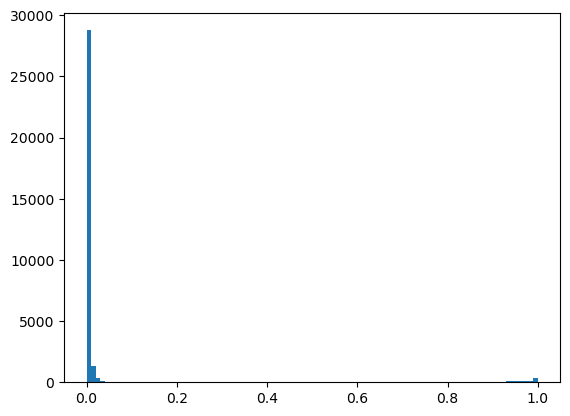

In [ ]:
plt.hist(test_preds, bins=100)
plt.show()

In [ ]:
def foo(l_rate, m_depth):
    m_depth = int(m_depth)

    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ]
    )

    categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop="if_binary")

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, var_numericas),
            ("cat", categorical_transformer, var_categoricas),
        ]
    )

    def add_model(data_pipeline, model) -> Pipeline:
        whole_pipeline = Pipeline([
            ("data_pipeline", data_pipeline),
            ("model", model)
        ])
        return whole_pipeline

    data_pipeline = Pipeline(steps=[
        ("data_processor", preprocessor),
    ])

    # Re-define the XGBoost classifier
    xgb_classifier = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        n_estimators=100,
        learning_rate=l_rate,
        max_depth=m_depth,
        seed=42
    )

    # Re-create the XGBoost pipeline
    pipeline_xgb = add_model(data_pipeline, xgb_classifier)

    pipeline_xgb.fit(X_train, y_train)

    test_preds = pipeline_xgb.predict_proba(X_test)[:, 1]
    ths = np.linspace(0, 1, 1000)
    best_th = ths[np.argmax([f1_score(y_test, test_preds>th) for th in ths])]
    best_th

    test_f1 = f1_score(y_test, test_preds>best_th)

    return test_f1

In [ ]:
pbounds = dict(
    l_rate = (0.01, 0.5),
    m_depth = (3, 10)
)

In [ ]:
optimizer = BayesianOptimization(
    f=foo,
    pbounds=pbounds,
    random_state=42,
    verbose=2,
)

In [ ]:
%%time
optimizer.maximize(
    init_points=5,
    n_iter=95
)

|   iter    |  target   |  l_rate   |  m_depth  |
-------------------------------------------------
| 1         | 0.9345    | 0.1935    | 9.655     |
| 2         | 0.9352    | 0.3687    | 7.191     |
| 3         | 0.9348    | 0.08645   | 4.092     |
| 4         | 0.9342    | 0.03846   | 9.063     |
| 5         | 0.9343    | 0.3045    | 7.957     |
| 6         | 0.9353    | 0.422     | 7.192     |
| 7         | 0.9347    | 0.5       | 6.914     |
| 8         | 0.9348    | 0.492     | 7.363     |
| 9         | 0.9353    | 0.4931    | 7.107     |
| 10        | 0.9343    | 0.01186   | 5.345     |
| 11        | 0.9356    | 0.3429    | 3.575     |
| 12        | 0.9355    | 0.4367    | 3.391     |
| 13        | 0.9357    | 0.1418    | 3.418     |
| 14        | 0.935     | 0.1109    | 3.088     |
| 15        | 0.9337    | 0.01143   | 3.618     |
| 16        | 0.9366    | 0.306     | 4.062     |
| 17        | 0.935     | 0.3994    | 4.025     |
| 18        | 0.9353    | 0.2742    | 4.091     |


| 100       | 0.9358    | 0.08027   | 6.167     |
CPU times: total: 31min 52s
Wall time: 15min


In [ ]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop="if_binary")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, var_numericas),
        ("cat", categorical_transformer, var_categoricas),
    ]
)

def add_model(data_pipeline, model) -> Pipeline:
    whole_pipeline = Pipeline([
        ("data_pipeline", data_pipeline),
        ("model", model)
    ])
    return whole_pipeline

data_pipeline = Pipeline(steps=[
    ("data_processor", preprocessor),
])

# Re-define the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.3971,
    max_depth=3,
    seed=42
)

# Re-create the XGBoost pipeline
pipeline_xgb = add_model(data_pipeline, xgb_classifier)

pipeline_xgb.fit(X_train, y_train)

test_preds = pipeline_xgb.predict_proba(X_test)[:, 1]
ths = np.linspace(0, 1, 1000)
best_th = ths[np.argmax([f1_score(y_test, test_preds>th) for th in ths])]
best_th

test_f1 = f1_score(y_test, test_preds>best_th)
test_f1

0.9366906474820144

In [ ]:
pipeline_xgb.fit(X_train_transformed, y_train_transformed)

Pipeline(steps=[('data_pipeline',
                 Pipeline(steps=[('data_processor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   Index(['EDAD', 'GRUPO_ETAREO', 'TSISTOLICA', 'TDIASTOLICA', 'CMes_6', 'CMes_5',
       'CMes_4', 'CMes_3', 'CMes_2', 'CMes_1', 'SMes_6', 'SMes_5', 'SMes_4',
       'SMes_3', 'SMes_2...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interactio

In [ ]:
# Aplicar la función tanto al conjunto de Prueba
X_test_transformed = Transformaciones(df_test)

In [ ]:
submission_pred = pipeline_xgb.predict_proba(X_test_transformed)[:, 1]
submission_pred_bool = submission_pred>best_th
submission_pred_int = [int(item) for item in submission_pred_bool]
submission = pd.DataFrame(data=dict(ID=df_test.index, Target=submission_pred_int))
submission.to_csv("submission_xgb.csv", index=False)

# Suport Vector Machine

In [ ]:
# Define an SVM classifier
svm_classifier = BaggingClassifier(SVC(
    probability=True,
    kernel='rbf',
    C=1.0,
    degree=3,
    gamma=0.01
), max_samples=0.1, random_state=42)

pipeline_svm = add_model(data_pipeline, svm_classifier)
pipeline_svm

Pipeline(steps=[('data_pipeline',
                 Pipeline(steps=[('data_processor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   Index(['EDAD', 'GRUPO_ETAREO', 'TSISTOLICA', 'TDIASTOLICA', 'CMes_6', 'CMes_5',
       'CMes_4', 'CMes_3', 'CMes_2', 'CMes_1', 'SMes_6', 'SMes_5', 'SMes_4',
       'SMes_3', 'SMes_2...
       'DIABETES_FAMILIAR', 'CORONARIOS_FAMILIAR', 'CEREBRAL_FAMILIAR',
       'ENFERMEDAD_RENAL_FAMILIAR', 'ALBUMINURIA', 'COLESTEROL_TOTAL',
       'CREATININA_EN_SUERO_ORINA_OTROS', 'HDL', 'HEMOGLOBINA',
       'HEMOGLOBINA_GLICOSILADA', 'LDL', 'RELACION_ALBUMINURIA_CREATINURIA',
       'TRIGLICERIDOS', 'UROANALISIS'],
      dtype='object'))]))])),
                ('model',
                 BaggingClassifier(estimator=SVC(gamma=0.01, probability=True),
                                   max_samples=0.1, random_state=42))])

In [ ]:
%%time
pipeline_svm.fit(X_train, y_train)

CPU times: total: 2min 29s
Wall time: 2min 40s


Pipeline(steps=[('data_pipeline',
                 Pipeline(steps=[('data_processor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   Index(['EDAD', 'GRUPO_ETAREO', 'TSISTOLICA', 'TDIASTOLICA', 'CMes_6', 'CMes_5',
       'CMes_4', 'CMes_3', 'CMes_2', 'CMes_1', 'SMes_6', 'SMes_5', 'SMes_4',
       'SMes_3', 'SMes_2...
       'DIABETES_FAMILIAR', 'CORONARIOS_FAMILIAR', 'CEREBRAL_FAMILIAR',
       'ENFERMEDAD_RENAL_FAMILIAR', 'ALBUMINURIA', 'COLESTEROL_TOTAL',
       'CREATININA_EN_SUERO_ORINA_OTROS', 'HDL', 'HEMOGLOBINA',
       'HEMOGLOBINA_GLICOSILADA', 'LDL', 'RELACION_ALBUMINURIA_CREATINURIA',
       'TRIGLICERIDOS', 'UROANALISIS'],
      dtype='object'))]))])),
                ('model',
                 BaggingClassifier(estimator=SVC(gamma=0.01, probability=True),
                                   max_samples=0.1, random_state=42))])

In [ ]:
test_preds = pipeline_svm.predict(X_test)

In [ ]:
pd.DataFrame(test_preds).value_counts()

0    32076
1        4
dtype: int64

In [ ]:
test_preds = pipeline_svm.predict_proba(X_test)[:, 1]
ths = np.linspace(0, 1, 1000)
best_th = ths[np.argmax([f1_score(y_test, test_preds>th) for th in ths])]
best_th

0.08608608608608609

In [ ]:
test_f1 = f1_score(y_test, test_preds>best_th)
print(f"Test f1: {test_f1}")

Test f1: 0.3216141852644451


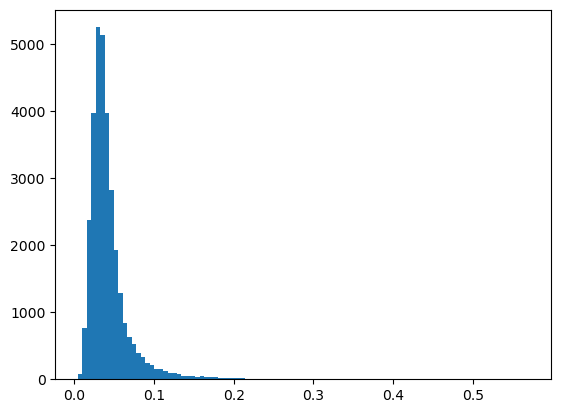

In [ ]:
plt.hist(test_preds, bins=100)
plt.show()

### Anotación BayesianOptimization
Se comentó el código del siguiente chunk con la finalidad de que la totalidad del código pueda ser ejecutada posteriormente, toda vez que luego de implementar durante 4 horas el optimizador Bayesian Optimization, este no realizó más de 3 iteraciones utilizando los siguientes parámetros:
* Init_points = 5 (puntos iniciales)
* n_iter = 5 (número de iteraciones)
Posteriormente, en un Super Vector Machine Clasiffier re – definido,  se utilizará  los mejores hyperparámetros, obtenidos en la tercera iteración ejecutada del optimizador Bayesian Optimization :

|Iter: 3     |  target: 0.1921    | pca_components: 0.03017   |   svm_c:  2.91   | svm_degree 4.497 | svm_gamma: 1.062     | svm_kernel: 0.1818   |


In [ ]:
# BayesianOptimization
# def train_predict(svm_kernel, svm_c, svm_degree, svm_gamma, pca_components):
#     if svm_kernel < 0.25: svm_kernel = "linear"
#     elif svm_kernel < 0.5: svm_kernel = "poly"
#     elif svm_kernel < 0.75: svm_kernel = "rbf"
#     elif svm_kernel < 1: svm_kernel = "sigmoid"

#     svm_degree=int(svm_degree)

#     numeric_transformer = Pipeline(
#         steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("pca", PCA(n_components=pca_components))]
#     )

#     categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop="if_binary")

#     preprocessor = ColumnTransformer(
#         transformers=[
#             ("num", numeric_transformer, var_numericas),
#             ("cat", categorical_transformer, var_categoricas),
#         ]
#     )

#     def add_model(data_pipeline, model) -> Pipeline:
#         whole_pipeline = Pipeline([
#             ("data_pipeline", data_pipeline),
#             ("model", model)
#         ])
#         return whole_pipeline

#     data_pipeline = Pipeline(steps=[
#         ("data_processor", preprocessor),
#     ])

#     # 3. Define an SVM classifier
#     svm_classifier = BaggingClassifier(SVC(
#         probability=True,
#         kernel=svm_kernel,
#         C=svm_c,
#         degree=svm_degree,
#         gamma=svm_gamma
#     ), max_samples=0.1, random_state=42)

#     # Re-create the SVM pipeline
#     pipeline_svm = add_model(data_pipeline, svm_classifier)

#     pipeline_svm.fit(X_train, y_train)

#     test_preds = pipeline_svm.predict_proba(X_test)[:, 1]
#     ths = np.linspace(0, 1, 1000)
#     best_th = ths[np.argmax([f1_score(y_test, test_preds>th) for th in ths])]
#     best_th

#     test_f1 = f1_score(y_test, test_preds>best_th)

#     return test_f1

In [ ]:
# pbounds = dict(
#     svm_kernel = (0, 1),
#     svm_c = (0.001, 3),
#     svm_degree=(2, 5),
#     svm_gamma=(0, 5),
#     pca_components=(0.01, 0.99)
# )

In [ ]:
# optimizer = BayesianOptimization(
#     f=train_predict,
#     pbounds=pbounds,
#     random_state=42,
#     verbose=2,
# )#

In [ ]:
# optimizer.maximize(
#     init_points=5,
#     n_iter=25
# )

|   iter    |  target   | pca_co... |   svm_c   | svm_de... | svm_gamma | svm_ke... |
-------------------------------------------------------------------------------------
| 1         | 0.1366    | 0.377     | 2.852     | 4.196     | 2.993     | 0.156     |
| 2         | 0.139     | 0.1629    | 0.1752    | 4.599     | 3.006     | 0.7081    |
| 3         | 0.1921    | 0.03017   | 2.91      | 4.497     | 1.062     | 0.1818    |


In [ ]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("PCA", PCA(n_components=0.03017))]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop="if_binary")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, var_numericas),
        ("cat", categorical_transformer, var_categoricas),
    ]
)

def add_model(data_pipeline, model) -> Pipeline:
    whole_pipeline = Pipeline([
        ("data_pipeline", data_pipeline),
        ("model", model)
    ])
    return whole_pipeline

data_pipeline = Pipeline(steps=[
    ("data_processor", preprocessor),
])

# Re-define the svm classifier
svm_classifier = BaggingClassifier(SVC(
        probability=True,
        kernel="linear",
        C=2.91,
        degree=4,
        gamma=1.062
    ), max_samples=0.1, random_state=42)

# Re-create the svm classifier pipeline
pipeline_svm = add_model(data_pipeline, svm_classifier)

pipeline_svm.fit(X_train, y_train)

test_preds = pipeline_svm.predict_proba(X_test)[:, 1]
ths = np.linspace(0, 1, 1000)
best_th = ths[np.argmax([f1_score(y_test, test_preds>th) for th in ths])]
best_th

test_f1 = f1_score(y_test, test_preds>best_th)
test_f1

0.14289385762014906

In [ ]:
pipeline_svm.fit(X_train_transformed, y_train_transformed)

Pipeline(steps=[('data_pipeline',
                 Pipeline(steps=[('data_processor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('PCA',
                                                                                    PCA(n_components=0.03017))]),
                                                                   Index(['EDAD', 'GRUPO_ETAREO', 'TSISTOLICA', 'TDIASTOLICA', 'CMes_6', 'CMes_5',
       'CMes_4', 'CMes_3', 'CMes_2', 'CMes_1', 'SMes_6',...
       'ENFERMEDAD_RENAL_FAMILIAR', 'ALBUMINURIA', 'COLESTEROL_TOTAL',
       'CREATININA_EN_SUERO_ORINA_OTROS', 'HDL', 'HEMOGLOBINA',
       'HEMOGLOBINA_GLICOSILADA', 'LDL', 'RELACION_ALBUMINURIA_CREATINURIA',
       'TRIGLICERIDOS', 'UROANALISIS'],
      dtype='object'))]))])),
                ('model',
                 BaggingClassifier(estimator=SVC(C=2.91, degree=4, gamma=1.062,
                                                 kernel='linear',
                                                 probability=True),
                                   max_samples=0.1, random_state=42))])

In [ ]:
# Aplicar la función tanto al conjunto de Prueba
X_test_transformed = Transformaciones(df_test)

In [ ]:
submission_pred = pipeline_svm.predict_proba(X_test_transformed)[:, 1]
submission_pred_bool = submission_pred>best_th
submission_pred_int = [int(item) for item in submission_pred_bool]
submission = pd.DataFrame(data=dict(ID=df_test.index, Target=submission_pred_int))
submission.to_csv("submission_svm.csv", index=False)

# Neuronal Network

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

# Define a neural network classifier
nn_classifier = MLPClassifier(hidden_layer_sizes=(100,50), max_iter=1000, alpha=0.0001,
                     solver='adam', verbose=10, random_state=42, tol=0.0001)

# Create the pipeline with neural network
pipeline_nn = add_model(data_pipeline, nn_classifier)
pipeline_nn

Pipeline(steps=[('data_pipeline',
                 Pipeline(steps=[('data_processor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('PCA',
                                                                                    PCA(n_components=0.03017))]),
                                                                   Index(['EDAD', 'GRUPO_ETAREO', 'TSISTOLICA', 'TDIASTOLICA', 'CMes_6', 'CMes_5',
       'CMes_4', 'CMes_3', 'CMes_2', 'CMes_1', 'SMes_6',...
       'DIABETES_FAMILIAR', 'CORONARIOS_FAMILIAR', 'CEREBRAL_FAMILIAR',
       'ENFERMEDAD_RENAL_FAMILIAR', 'ALBUMINURIA', 'COLESTEROL_TOTAL',
       'CREATININA_EN_SUERO_ORINA_OTROS', 'HDL', 'HEMOGLOBINA',
       'HEMOGLOBINA_GLICOSILADA', 'LDL', 'RELACION_ALBUMINURIA_CREATINURIA',
       'TRIGLICERIDOS', 'UROANALISIS'],
      dtype='object'))]))])),
                ('model',
                 MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000,
                               random_state=42, verbose=10))])

In [ ]:
%%time
pipeline_nn.fit(X_train, y_train)

Iteration 1, loss = 0.16579253
Iteration 2, loss = 0.15310410
Iteration 3, loss = 0.15261728
Iteration 4, loss = 0.15210716
Iteration 5, loss = 0.15183774
Iteration 6, loss = 0.15133017
Iteration 7, loss = 0.15098369
Iteration 8, loss = 0.15060859
Iteration 9, loss = 0.15045435
Iteration 10, loss = 0.14995629
Iteration 11, loss = 0.14954234
Iteration 12, loss = 0.14940555
Iteration 13, loss = 0.14906391
Iteration 14, loss = 0.14878982
Iteration 15, loss = 0.14841265
Iteration 16, loss = 0.14824830
Iteration 17, loss = 0.14798267
Iteration 18, loss = 0.14782325
Iteration 19, loss = 0.14767372
Iteration 20, loss = 0.14710081
Iteration 21, loss = 0.14684806
Iteration 22, loss = 0.14642722
Iteration 23, loss = 0.14628543
Iteration 24, loss = 0.14597288
Iteration 25, loss = 0.14559350
Iteration 26, loss = 0.14534526
Iteration 27, loss = 0.14498858
Iteration 28, loss = 0.14471678
Iteration 29, loss = 0.14447642
Iteration 30, loss = 0.14410262
Iteration 31, loss = 0.14370296
Iteration 32, los

Iteration 253, loss = 0.11599781
Iteration 254, loss = 0.11577369
Iteration 255, loss = 0.11552953
Iteration 256, loss = 0.11566498
Iteration 257, loss = 0.11565823
Iteration 258, loss = 0.11572027
Iteration 259, loss = 0.11585084
Iteration 260, loss = 0.11563221
Iteration 261, loss = 0.11544428
Iteration 262, loss = 0.11541356
Iteration 263, loss = 0.11504052
Iteration 264, loss = 0.11545512
Iteration 265, loss = 0.11530244
Iteration 266, loss = 0.11572497
Iteration 267, loss = 0.11517691
Iteration 268, loss = 0.11523118
Iteration 269, loss = 0.11512300
Iteration 270, loss = 0.11532597
Iteration 271, loss = 0.11487114
Iteration 272, loss = 0.11507484
Iteration 273, loss = 0.11509522
Iteration 274, loss = 0.11492024
Iteration 275, loss = 0.11489395
Iteration 276, loss = 0.11485063
Iteration 277, loss = 0.11470892
Iteration 278, loss = 0.11489574
Iteration 279, loss = 0.11501707
Iteration 280, loss = 0.11476767
Iteration 281, loss = 0.11468434
Iteration 282, loss = 0.11448583
Iteration 

Pipeline(steps=[('data_pipeline',
                 Pipeline(steps=[('data_processor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('PCA',
                                                                                    PCA(n_components=0.03017))]),
                                                                   Index(['EDAD', 'GRUPO_ETAREO', 'TSISTOLICA', 'TDIASTOLICA', 'CMes_6', 'CMes_5',
       'CMes_4', 'CMes_3', 'CMes_2', 'CMes_1', 'SMes_6',...
       'DIABETES_FAMILIAR', 'CORONARIOS_FAMILIAR', 'CEREBRAL_FAMILIAR',
       'ENFERMEDAD_RENAL_FAMILIAR', 'ALBUMINURIA', 'COLESTEROL_TOTAL',
       'CREATININA_EN_SUERO_ORINA_OTROS', 'HDL', 'HEMOGLOBINA',
       'HEMOGLOBINA_GLICOSILADA', 'LDL', 'RELACION_ALBUMINURIA_CREATINURIA',
       'TRIGLICERIDOS', 'UROANALISIS'],
      dtype='object'))]))])),
                ('model',
                 MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000,
                               random_state=42, verbose=10))])

In [ ]:
test_preds = pipeline_nn.predict(X_test)

In [ ]:
pd.DataFrame(test_preds).value_counts()

0    31680
1      400
dtype: int64

In [ ]:
test_preds = pipeline_nn.predict_proba(X_test)[:, 1]
ths = np.linspace(0, 1, 1000)
best_th = ths[np.argmax([f1_score(y_test, test_preds>th) for th in ths])]
best_th

0.11411411411411411

In [ ]:
test_f1 = f1_score(y_test, test_preds>best_th)
print(f"Test f1: {test_f1}")

Test f1: 0.18206460356900836


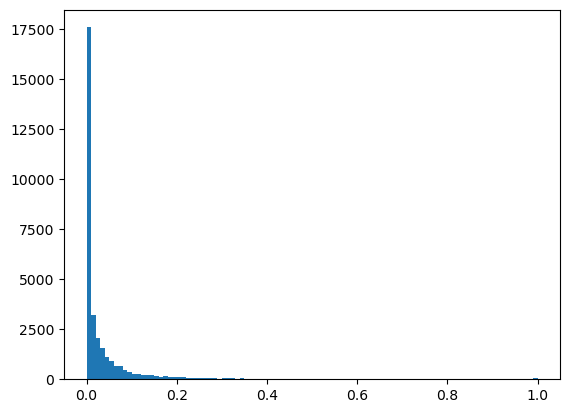

In [ ]:
plt.hist(test_preds, bins=100)
plt.show()

In [ ]:
def train_predict(nn_hidden_layer_1_size, nn_hidden_layer_2_size, nn_max_iter, nn_alpha, nn_solver, nn_tol, pca_components):

    nn_hidden_layer_1_size = int(nn_hidden_layer_1_size)
    nn_hidden_layer_2_size = int(nn_hidden_layer_2_size)
    nn_max_iter = int(nn_max_iter)

    if nn_solver < 0.33: nn_solver = "lbfgs"
    elif nn_solver < 0.66: nn_solver = "sgd"
    elif nn_solver < 1: nn_solver = "adam"

    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("pca", PCA(n_components=pca_components))]
    )

    categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop="if_binary")

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, var_numericas),
            ("cat", categorical_transformer, var_categoricas),
        ]
    )

    def add_model(data_pipeline, model) -> Pipeline:
        whole_pipeline = Pipeline([
            ("data_pipeline", data_pipeline),
            ("model", model)
        ])
        return whole_pipeline

    data_pipeline = Pipeline(steps=[
        ("data_processor", preprocessor),
    ])

    # 3. Define an NN classifier
    nn_classifier = MLPClassifier(
        hidden_layer_sizes=(nn_hidden_layer_1_size, nn_hidden_layer_2_size),
        max_iter=nn_max_iter,
        alpha=nn_alpha,
        solver=nn_solver,
        verbose=10,
        random_state=42,
        tol=nn_tol
    )

    # Re-create the NN pipeline
    pipeline_nn = add_model(data_pipeline, nn_classifier)

    pipeline_nn.fit(X_train, y_train)

    test_preds = pipeline_nn.predict_proba(X_test)[:, 1]
    ths = np.linspace(0, 1, 1000)
    best_th = ths[np.argmax([f1_score(y_test, test_preds>th) for th in ths])]
    best_th

    test_f1 = f1_score(y_test, test_preds>best_th)

    return test_f1

In [ ]:
pbounds = dict(
    nn_hidden_layer_1_size=(50, 100),
    nn_hidden_layer_2_size=(25, 50),
    nn_max_iter=(500, 1000),
    nn_alpha=(0.00001, 0.0002),
    nn_solver=(0, 1),
    nn_tol=(0.00001, 0.0002),
    pca_components=(0.01, 0.99)
)

In [ ]:
optimizer = BayesianOptimization(
    f=train_predict,
    pbounds=pbounds,
    random_state=42,
    verbose=2,
)

In [ ]:
%%time
optimizer.maximize(
    init_points=5,
    n_iter=25
)

|   iter    |  target   | nn_alpha  | nn_hid... | nn_hid... | nn_max... | nn_solver |  nn_tol   | pca_co... |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.1972    | 8.116e-05 | 97.54     | 43.3      | 799.3     | 0.156     | 3.964e-05 | 0.06692   |
Iteration 1, loss = 0.16906627
Iteration 2, loss = 0.15343405
Iteration 3, loss = 0.15279995
Iteration 4, loss = 0.15236925
Iteration 5, loss = 0.15178210
Iteration 6, loss = 0.15137580
Iteration 7, loss = 0.15107208
Iteration 8, loss = 0.15058048
Iteration 9, loss = 0.15035798
Iteration 10, loss = 0.15002308
Iteration 11, loss = 0.14970665
Iteration 12, loss = 0.14937253
Iteration 13, loss = 0.14918691
Iteration 14, loss = 0.14894644
Iteration 15, loss = 0.14873120
Iteration 16, loss = 0.14833590
Iteration 17, loss = 0.14820701
Iteration 18, loss = 0.14805388
Iteration 19, loss = 0.14774099
Iteration 20, loss = 0.14750352
Iteration 21, loss = 0.14731226
Iterati

Iteration 51, loss = 0.13671385
Iteration 52, loss = 0.13619311
Iteration 53, loss = 0.13610613
Iteration 54, loss = 0.13608681
Iteration 55, loss = 0.13573992
Iteration 56, loss = 0.13576200
Iteration 57, loss = 0.13566673
Iteration 58, loss = 0.13533686
Iteration 59, loss = 0.13514427
Iteration 60, loss = 0.13519277
Iteration 61, loss = 0.13497089
Iteration 62, loss = 0.13471913
Iteration 63, loss = 0.13458392
Iteration 64, loss = 0.13450508
Iteration 65, loss = 0.13436610
Iteration 66, loss = 0.13408212
Iteration 67, loss = 0.13408708
Iteration 68, loss = 0.13390213
Iteration 69, loss = 0.13375862
Iteration 70, loss = 0.13364520
Iteration 71, loss = 0.13343531
Iteration 72, loss = 0.13325753
Iteration 73, loss = 0.13332438
Iteration 74, loss = 0.13313011
Iteration 75, loss = 0.13299964
Iteration 76, loss = 0.13280234
Iteration 77, loss = 0.13289145
Iteration 78, loss = 0.13296743
Iteration 79, loss = 0.13244814
Iteration 80, loss = 0.13252172
Iteration 81, loss = 0.13223034
Iteratio

| 6         | 0.7231    | 0.0001633 | 50.0      | 48.37     | 613.2     | 0.0       | 0.0002    | 0.99      |
Iteration 1, loss = 0.20425908
Iteration 2, loss = 0.16779744
Iteration 3, loss = 0.16252136
Iteration 4, loss = 0.15920386
Iteration 5, loss = 0.15707796
Iteration 6, loss = 0.15562129
Iteration 7, loss = 0.15464151
Iteration 8, loss = 0.15392615
Iteration 9, loss = 0.15339651
Iteration 10, loss = 0.15298486
Iteration 11, loss = 0.15263384
Iteration 12, loss = 0.15235609
Iteration 13, loss = 0.15210819
Iteration 14, loss = 0.15191506
Iteration 15, loss = 0.15172685
Iteration 16, loss = 0.15155368
Iteration 17, loss = 0.15141555
Iteration 18, loss = 0.15127734
Iteration 19, loss = 0.15115408
Iteration 20, loss = 0.15103675
Iteration 21, loss = 0.15094179
Iteration 22, loss = 0.15082776
Iteration 23, loss = 0.15074322
Iteration 24, loss = 0.15067970
Iteration 25, loss = 0.15060904
Iteration 26, loss = 0.15052750
Iteration 27, loss = 0.15048016
Iteration 28, loss = 0.15041091
Ite

Iteration 211, loss = 0.10749659
Iteration 212, loss = 0.10705977
Iteration 213, loss = 0.10738370
Iteration 214, loss = 0.10724752
Iteration 215, loss = 0.10741920
Iteration 216, loss = 0.10693852
Iteration 217, loss = 0.10717026
Iteration 218, loss = 0.10706145
Iteration 219, loss = 0.10695734
Iteration 220, loss = 0.10683416
Iteration 221, loss = 0.10683394
Iteration 222, loss = 0.10732716
Iteration 223, loss = 0.10668915
Iteration 224, loss = 0.10675672
Iteration 225, loss = 0.10670101
Iteration 226, loss = 0.10668779
Iteration 227, loss = 0.10656864
Iteration 228, loss = 0.10666663
Iteration 229, loss = 0.10655874
Iteration 230, loss = 0.10656843
Iteration 231, loss = 0.10652673
Iteration 232, loss = 0.10635917
Iteration 233, loss = 0.10623463
Iteration 234, loss = 0.10625917
Iteration 235, loss = 0.10634429
Iteration 236, loss = 0.10643341
Iteration 237, loss = 0.10630895
Iteration 238, loss = 0.10633922
Iteration 239, loss = 0.10620594
Iteration 240, loss = 0.10614840
Iteration 

Iteration 74, loss = 0.13685294
Iteration 75, loss = 0.13689353
Iteration 76, loss = 0.13647118
Iteration 77, loss = 0.13671789
Iteration 78, loss = 0.13652531
Iteration 79, loss = 0.13645848
Iteration 80, loss = 0.13641477
Iteration 81, loss = 0.13619442
Iteration 82, loss = 0.13610423
Iteration 83, loss = 0.13592851
Iteration 84, loss = 0.13582957
Iteration 85, loss = 0.13586477
Iteration 86, loss = 0.13590665
Iteration 87, loss = 0.13546383
Iteration 88, loss = 0.13584125
Iteration 89, loss = 0.13538172
Iteration 90, loss = 0.13549358
Iteration 91, loss = 0.13534717
Iteration 92, loss = 0.13497579
Iteration 93, loss = 0.13538900
Iteration 94, loss = 0.13507010
Iteration 95, loss = 0.13497326
Iteration 96, loss = 0.13498463
Iteration 97, loss = 0.13487007
Iteration 98, loss = 0.13472982
Iteration 99, loss = 0.13468738
Iteration 100, loss = 0.13471270
Iteration 101, loss = 0.13437408
Iteration 102, loss = 0.13450307
Iteration 103, loss = 0.13424665
Iteration 104, loss = 0.13427717
Ite

Iteration 80, loss = 0.13464204
Iteration 81, loss = 0.13417738
Iteration 82, loss = 0.13414801
Iteration 83, loss = 0.13416119
Iteration 84, loss = 0.13397625
Iteration 85, loss = 0.13365342
Iteration 86, loss = 0.13363863
Iteration 87, loss = 0.13338583
Iteration 88, loss = 0.13320359
Iteration 89, loss = 0.13319116
Iteration 90, loss = 0.13297006
Iteration 91, loss = 0.13306429
Iteration 92, loss = 0.13263841
Iteration 93, loss = 0.13258131
Iteration 94, loss = 0.13234378
Iteration 95, loss = 0.13216668
Iteration 96, loss = 0.13213995
Iteration 97, loss = 0.13178953
Iteration 98, loss = 0.13190737
Iteration 99, loss = 0.13161715
Iteration 100, loss = 0.13176335
Iteration 101, loss = 0.13144598
Iteration 102, loss = 0.13116300
Iteration 103, loss = 0.13114269
Iteration 104, loss = 0.13107752
Iteration 105, loss = 0.13103036
Iteration 106, loss = 0.13094596
Iteration 107, loss = 0.13076146
Iteration 108, loss = 0.13068771
Iteration 109, loss = 0.13058010
Iteration 110, loss = 0.130594

Iteration 96, loss = 0.13189717
Iteration 97, loss = 0.13177064
Iteration 98, loss = 0.13163749
Iteration 99, loss = 0.13179535
Iteration 100, loss = 0.13146007
Iteration 101, loss = 0.13154988
Iteration 102, loss = 0.13143199
Iteration 103, loss = 0.13138471
Iteration 104, loss = 0.13112359
Iteration 105, loss = 0.13114977
Iteration 106, loss = 0.13093791
Iteration 107, loss = 0.13084609
Iteration 108, loss = 0.13066417
Iteration 109, loss = 0.13069451
Iteration 110, loss = 0.13062209
Iteration 111, loss = 0.13048853
Iteration 112, loss = 0.13036349
Iteration 113, loss = 0.13012663
Iteration 114, loss = 0.13025496
Iteration 115, loss = 0.13003646
Iteration 116, loss = 0.12990150
Iteration 117, loss = 0.12981551
Iteration 118, loss = 0.12978074
Iteration 119, loss = 0.12982284
Iteration 120, loss = 0.12938218
Iteration 121, loss = 0.12960872
Iteration 122, loss = 0.12924953
Iteration 123, loss = 0.12942892
Iteration 124, loss = 0.12922944
Iteration 125, loss = 0.12916251
Iteration 126,

Iteration 345, loss = 0.12003575
Iteration 346, loss = 0.12004803
Iteration 347, loss = 0.12010237
Iteration 348, loss = 0.11984159
Iteration 349, loss = 0.11981216
Iteration 350, loss = 0.11987116
Iteration 351, loss = 0.12011100
Iteration 352, loss = 0.11991346
Iteration 353, loss = 0.12004952
Iteration 354, loss = 0.12002603
Iteration 355, loss = 0.11989424
Iteration 356, loss = 0.11978643
Iteration 357, loss = 0.11960700
Iteration 358, loss = 0.11973267
Iteration 359, loss = 0.11982462
Iteration 360, loss = 0.11980999
Iteration 361, loss = 0.11966711
Iteration 362, loss = 0.11954621
Iteration 363, loss = 0.11964181
Iteration 364, loss = 0.11945138
Iteration 365, loss = 0.11980300
Iteration 366, loss = 0.11952895
Iteration 367, loss = 0.11965483
Iteration 368, loss = 0.11953896
Iteration 369, loss = 0.11966239
Iteration 370, loss = 0.11982069
Iteration 371, loss = 0.11938362
Iteration 372, loss = 0.11953557
Iteration 373, loss = 0.11951401
Iteration 374, loss = 0.11960964
Iteration 

Iteration 183, loss = 0.03566323
Iteration 184, loss = 0.03588137
Iteration 185, loss = 0.03611365
Iteration 186, loss = 0.03578780
Iteration 187, loss = 0.03538066
Iteration 188, loss = 0.03533053
Iteration 189, loss = 0.03459437
Iteration 190, loss = 0.03537035
Iteration 191, loss = 0.03554872
Iteration 192, loss = 0.03483381
Iteration 193, loss = 0.03519352
Iteration 194, loss = 0.03441937
Iteration 195, loss = 0.03522652
Iteration 196, loss = 0.03436208
Iteration 197, loss = 0.03413938
Iteration 198, loss = 0.03464519
Iteration 199, loss = 0.03387660
Iteration 200, loss = 0.03444091
Iteration 201, loss = 0.03450904
Iteration 202, loss = 0.03422888
Iteration 203, loss = 0.03364335
Iteration 204, loss = 0.03405783
Iteration 205, loss = 0.03349304
Iteration 206, loss = 0.03274074
Iteration 207, loss = 0.03420507
Iteration 208, loss = 0.03357405
Iteration 209, loss = 0.03289114
Iteration 210, loss = 0.03305601
Iteration 211, loss = 0.03375225
Iteration 212, loss = 0.03360296
Iteration 

Iteration 210, loss = 0.10974439
Iteration 211, loss = 0.10966099
Iteration 212, loss = 0.10969772
Iteration 213, loss = 0.10976834
Iteration 214, loss = 0.10974204
Iteration 215, loss = 0.10943670
Iteration 216, loss = 0.10948003
Iteration 217, loss = 0.10938592
Iteration 218, loss = 0.10930293
Iteration 219, loss = 0.10921042
Iteration 220, loss = 0.10924575
Iteration 221, loss = 0.10893261
Iteration 222, loss = 0.10909961
Iteration 223, loss = 0.10866962
Iteration 224, loss = 0.10885900
Iteration 225, loss = 0.10888915
Iteration 226, loss = 0.10858287
Iteration 227, loss = 0.10873210
Iteration 228, loss = 0.10856360
Iteration 229, loss = 0.10843596
Iteration 230, loss = 0.10867920
Iteration 231, loss = 0.10829415
Iteration 232, loss = 0.10826130
Iteration 233, loss = 0.10844144
Iteration 234, loss = 0.10845739
Iteration 235, loss = 0.10825925
Iteration 236, loss = 0.10790543
Iteration 237, loss = 0.10839112
Iteration 238, loss = 0.10795128
Iteration 239, loss = 0.10783774
Iteration 

Iteration 67, loss = 0.13618978
Iteration 68, loss = 0.13614318
Iteration 69, loss = 0.13607710
Iteration 70, loss = 0.13598522
Iteration 71, loss = 0.13593288
Iteration 72, loss = 0.13585707
Iteration 73, loss = 0.13579306
Iteration 74, loss = 0.13571641
Iteration 75, loss = 0.13564780
Iteration 76, loss = 0.13560063
Iteration 77, loss = 0.13553706
Iteration 78, loss = 0.13544328
Iteration 79, loss = 0.13539608
Iteration 80, loss = 0.13531815
Iteration 81, loss = 0.13528541
Iteration 82, loss = 0.13520029
Iteration 83, loss = 0.13514973
Iteration 84, loss = 0.13506287
Iteration 85, loss = 0.13504918
Iteration 86, loss = 0.13496362
Iteration 87, loss = 0.13491579
Iteration 88, loss = 0.13486039
Iteration 89, loss = 0.13476723
Iteration 90, loss = 0.13474624
Iteration 91, loss = 0.13468986
Iteration 92, loss = 0.13462731
Iteration 93, loss = 0.13457674
Iteration 94, loss = 0.13452795
Iteration 95, loss = 0.13446684
Iteration 96, loss = 0.13439523
Iteration 97, loss = 0.13436719
Iteratio

Iteration 317, loss = 0.12530373
Iteration 318, loss = 0.12527005
Iteration 319, loss = 0.12525844
Iteration 320, loss = 0.12526701
Iteration 321, loss = 0.12519372
Iteration 322, loss = 0.12513513
Iteration 323, loss = 0.12511163
Iteration 324, loss = 0.12507439
Iteration 325, loss = 0.12506668
Iteration 326, loss = 0.12500517
Iteration 327, loss = 0.12498086
Iteration 328, loss = 0.12489350
Iteration 329, loss = 0.12493403
Iteration 330, loss = 0.12487662
Iteration 331, loss = 0.12485259
Iteration 332, loss = 0.12475973
Iteration 333, loss = 0.12476496
Iteration 334, loss = 0.12471362
Iteration 335, loss = 0.12468566
Iteration 336, loss = 0.12466095
Iteration 337, loss = 0.12459780
Iteration 338, loss = 0.12452807
Iteration 339, loss = 0.12449828
Iteration 340, loss = 0.12451790
Iteration 341, loss = 0.12445381
Iteration 342, loss = 0.12441496
Iteration 343, loss = 0.12440314
Iteration 344, loss = 0.12436439
Iteration 345, loss = 0.12428909
Iteration 346, loss = 0.12427531
Iteration 

Iteration 566, loss = 0.07760962
Iteration 567, loss = 0.07743336
Iteration 568, loss = 0.07713994
Iteration 569, loss = 0.07682129
Iteration 570, loss = 0.07651473
Iteration 571, loss = 0.07619152
Iteration 572, loss = 0.07609569
Iteration 573, loss = 0.07568874
Iteration 574, loss = 0.07514657
Iteration 575, loss = 0.07498016
Iteration 576, loss = 0.07453590
Iteration 577, loss = 0.07430001
Iteration 578, loss = 0.07410728
Iteration 579, loss = 0.07392575
Iteration 580, loss = 0.07378959
Iteration 581, loss = 0.07340052
Iteration 582, loss = 0.07322995
Iteration 583, loss = 0.07315806
Iteration 584, loss = 0.07276283
Iteration 585, loss = 0.07241560
Iteration 586, loss = 0.07236527
Iteration 587, loss = 0.07218036
Iteration 588, loss = 0.07168475
Iteration 589, loss = 0.07170674
Iteration 590, loss = 0.07143009
Iteration 591, loss = 0.07131244
Iteration 592, loss = 0.07117761
Iteration 593, loss = 0.07100224
Iteration 594, loss = 0.07074107
Iteration 595, loss = 0.07046557
Iteration 

Iteration 17, loss = 0.14659135
Iteration 18, loss = 0.14639698
Iteration 19, loss = 0.14623932
Iteration 20, loss = 0.14605889
Iteration 21, loss = 0.14592170
Iteration 22, loss = 0.14580567
Iteration 23, loss = 0.14563709
Iteration 24, loss = 0.14556755
Iteration 25, loss = 0.14543550
Iteration 26, loss = 0.14531374
Iteration 27, loss = 0.14522628
Iteration 28, loss = 0.14511373
Iteration 29, loss = 0.14502222
Iteration 30, loss = 0.14493860
Iteration 31, loss = 0.14483152
Iteration 32, loss = 0.14473684
Iteration 33, loss = 0.14465837
Iteration 34, loss = 0.14458452
Iteration 35, loss = 0.14448890
Iteration 36, loss = 0.14443075
Iteration 37, loss = 0.14432267
Training loss did not improve more than tol=0.000118 for 10 consecutive epochs. Stopping.
| 17        | 0.2818    | 0.0001578 | 85.72     | 39.96     | 513.0     | 0.4421    | 0.0001182 | 0.6722    |
Iteration 1, loss = 0.15251466
Iteration 2, loss = 0.14019105
Iteration 3, loss = 0.13834680
Iteration 4, loss = 0.13707785
Iter

Iteration 224, loss = 0.09322245
Iteration 225, loss = 0.09319228
Iteration 226, loss = 0.09330954
Iteration 227, loss = 0.09310949
Iteration 228, loss = 0.09291120
Iteration 229, loss = 0.09270364
Iteration 230, loss = 0.09261143
Iteration 231, loss = 0.09287494
Iteration 232, loss = 0.09264993
Iteration 233, loss = 0.09293478
Iteration 234, loss = 0.09240023
Iteration 235, loss = 0.09256555
Iteration 236, loss = 0.09261563
Iteration 237, loss = 0.09242370
Iteration 238, loss = 0.09227431
Iteration 239, loss = 0.09223949
Iteration 240, loss = 0.09217613
Iteration 241, loss = 0.09201633
Iteration 242, loss = 0.09224226
Iteration 243, loss = 0.09193363
Iteration 244, loss = 0.09211252
Iteration 245, loss = 0.09194807
Iteration 246, loss = 0.09211755
Iteration 247, loss = 0.09173320
Iteration 248, loss = 0.09192483
Iteration 249, loss = 0.09152068
Iteration 250, loss = 0.09161268
Iteration 251, loss = 0.09192427
Iteration 252, loss = 0.09160611
Iteration 253, loss = 0.09133429
Iteration 

Iteration 99, loss = 0.13754667
Iteration 100, loss = 0.13753061
Iteration 101, loss = 0.13748332
Iteration 102, loss = 0.13743938
Iteration 103, loss = 0.13742945
Iteration 104, loss = 0.13739723
Iteration 105, loss = 0.13735757
Iteration 106, loss = 0.13733492
Training loss did not improve more than tol=0.000049 for 10 consecutive epochs. Stopping.
| 20        | 0.3001    | 0.0001518 | 66.92     | 36.33     | 828.0     | 0.6258    | 4.897e-05 | 0.7425    |
| 21        | 0.2382    | 0.0001883 | 89.54     | 31.36     | 847.5     | 0.2209    | 0.0001332 | 0.7319    |
Iteration 1, loss = 0.20705914
Iteration 2, loss = 0.16339362
Iteration 3, loss = 0.15668521
Iteration 4, loss = 0.15283953
Iteration 5, loss = 0.15032242
Iteration 6, loss = 0.14855181
Iteration 7, loss = 0.14721140
Iteration 8, loss = 0.14616837
Iteration 9, loss = 0.14532293
Iteration 10, loss = 0.14461404
Iteration 11, loss = 0.14400332
Iteration 12, loss = 0.14347910
Iteration 13, loss = 0.14303559
Iteration 14, loss =

Iteration 49, loss = 0.11539735
Iteration 50, loss = 0.11531666
Iteration 51, loss = 0.11486519
Iteration 52, loss = 0.11463219
Iteration 53, loss = 0.11483042
Iteration 54, loss = 0.11428116
Iteration 55, loss = 0.11386724
Iteration 56, loss = 0.11372238
Iteration 57, loss = 0.11348634
Iteration 58, loss = 0.11343796
Iteration 59, loss = 0.11295041
Iteration 60, loss = 0.11271601
Iteration 61, loss = 0.11237804
Iteration 62, loss = 0.11219775
Iteration 63, loss = 0.11213374
Iteration 64, loss = 0.11194289
Iteration 65, loss = 0.11185901
Iteration 66, loss = 0.11154325
Iteration 67, loss = 0.11134841
Iteration 68, loss = 0.11096873
Iteration 69, loss = 0.11097888
Iteration 70, loss = 0.11053528
Iteration 71, loss = 0.11072054
Iteration 72, loss = 0.11026508
Iteration 73, loss = 0.11006057
Iteration 74, loss = 0.10998350
Iteration 75, loss = 0.10974740
Iteration 76, loss = 0.10956457
Iteration 77, loss = 0.10940597
Iteration 78, loss = 0.10937271
Iteration 79, loss = 0.10910108
Iteratio

Iteration 57, loss = 0.13861407
Iteration 58, loss = 0.13853257
Iteration 59, loss = 0.13811961
Iteration 60, loss = 0.13807797
Iteration 61, loss = 0.13785901
Iteration 62, loss = 0.13762778
Iteration 63, loss = 0.13761378
Iteration 64, loss = 0.13732810
Iteration 65, loss = 0.13718090
Iteration 66, loss = 0.13722981
Iteration 67, loss = 0.13685543
Iteration 68, loss = 0.13682641
Iteration 69, loss = 0.13666284
Iteration 70, loss = 0.13654026
Iteration 71, loss = 0.13628981
Iteration 72, loss = 0.13606473
Iteration 73, loss = 0.13584504
Iteration 74, loss = 0.13596685
Iteration 75, loss = 0.13583495
Iteration 76, loss = 0.13555234
Iteration 77, loss = 0.13554879
Iteration 78, loss = 0.13541296
Iteration 79, loss = 0.13544917
Iteration 80, loss = 0.13494795
Iteration 81, loss = 0.13481567
Iteration 82, loss = 0.13514052
Iteration 83, loss = 0.13467626
Iteration 84, loss = 0.13488513
Iteration 85, loss = 0.13447166
Iteration 86, loss = 0.13450976
Iteration 87, loss = 0.13424948
Iteratio

Iteration 307, loss = 0.12197443
Iteration 308, loss = 0.12203257
Iteration 309, loss = 0.12212560
Iteration 310, loss = 0.12204482
Iteration 311, loss = 0.12180038
Iteration 312, loss = 0.12189114
Iteration 313, loss = 0.12185652
Iteration 314, loss = 0.12202116
Iteration 315, loss = 0.12177990
Iteration 316, loss = 0.12188040
Iteration 317, loss = 0.12192018
Iteration 318, loss = 0.12187511
Iteration 319, loss = 0.12169957
Iteration 320, loss = 0.12147751
Iteration 321, loss = 0.12181164
Iteration 322, loss = 0.12168349
Iteration 323, loss = 0.12132118
Iteration 324, loss = 0.12146862
Iteration 325, loss = 0.12175115
Iteration 326, loss = 0.12158454
Iteration 327, loss = 0.12160807
Iteration 328, loss = 0.12158614
Iteration 329, loss = 0.12143968
Iteration 330, loss = 0.12170630
Iteration 331, loss = 0.12151235
Iteration 332, loss = 0.12133875
Iteration 333, loss = 0.12161578
Iteration 334, loss = 0.12138960
Training loss did not improve more than tol=0.000014 for 10 consecutive epoc

Iteration 178, loss = 0.08688416
Iteration 179, loss = 0.08656080
Iteration 180, loss = 0.08624277
Iteration 181, loss = 0.08605649
Iteration 182, loss = 0.08663598
Iteration 183, loss = 0.08637204
Iteration 184, loss = 0.08626560
Iteration 185, loss = 0.08616796
Iteration 186, loss = 0.08594024
Iteration 187, loss = 0.08601886
Iteration 188, loss = 0.08570323
Iteration 189, loss = 0.08585528
Iteration 190, loss = 0.08566711
Iteration 191, loss = 0.08560490
Iteration 192, loss = 0.08553272
Iteration 193, loss = 0.08516979
Iteration 194, loss = 0.08547122
Iteration 195, loss = 0.08516267
Iteration 196, loss = 0.08542233
Iteration 197, loss = 0.08477237
Iteration 198, loss = 0.08516689
Iteration 199, loss = 0.08510942
Iteration 200, loss = 0.08483024
Iteration 201, loss = 0.08457160
Iteration 202, loss = 0.08526767
Iteration 203, loss = 0.08473161
Iteration 204, loss = 0.08479170
Iteration 205, loss = 0.08439821
Iteration 206, loss = 0.08484239
Iteration 207, loss = 0.08443645
Iteration 

In [ ]:
optimizer.max

{'target': 0.723051409618574,
 'params': {'nn_alpha': 0.00016329587688922474,
  'nn_hidden_layer_1_size': 50.0,
  'nn_hidden_layer_2_size': 48.3672999052824,
  'nn_max_iter': 613.1540666046562,
  'nn_solver': 0.0,
  'nn_tol': 0.0002,
  'pca_components': 0.99}}

In [ ]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("pca", PCA(n_components=0.99))]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop="if_binary")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, var_numericas),
        ("cat", categorical_transformer, var_categoricas),
    ]
)

def add_model(data_pipeline, model) -> Pipeline:
    whole_pipeline = Pipeline([
        ("data_pipeline", data_pipeline),
        ("model", model)
    ])
    return whole_pipeline

data_pipeline = Pipeline(steps=[
    ("data_processor", preprocessor),
])

# Re-define the NN classifier
nn_classifier = MLPClassifier(
    hidden_layer_sizes=(50, 48),
    max_iter=613,
    alpha=0.00016329587688922474,
    solver="lbfgs",
    verbose=10,
    random_state=42,
    tol=0.0002
)

# Re-create the Neuronal Network pipeline
pipeline_nn = add_model(data_pipeline, nn_classifier)
pipeline_nn.fit(X_train, y_train)

test_preds = pipeline_nn.predict_proba(X_test)[:, 1]
ths = np.linspace(0, 1, 1000)
best_th = ths[np.argmax([f1_score(y_test, test_preds>th) for th in ths])]
best_th

test_f1 = f1_score(y_test, test_preds>best_th)
test_f1

0.723051409618574

In [ ]:
pipeline_nn.fit(X_train_transformed, y_train_transformed)

Pipeline(steps=[('data_pipeline',
                 Pipeline(steps=[('data_processor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('pca',
                                                                                    PCA(n_components=0.99))]),
                                                                   Index(['EDAD', 'GRUPO_ETAREO', 'TSISTOLICA', 'TDIASTOLICA', 'CMes_6', 'CMes_5',
       'CMes_4', 'CMes_3', 'CMes_2', 'CMes_1', 'SMes_6', 'SM...
       'ENFERMEDAD_RENAL_FAMILIAR', 'ALBUMINURIA', 'COLESTEROL_TOTAL',
       'CREATININA_EN_SUERO_ORINA_OTROS', 'HDL', 'HEMOGLOBINA',
       'HEMOGLOBINA_GLICOSILADA', 'LDL', 'RELACION_ALBUMINURIA_CREATINURIA',
       'TRIGLICERIDOS', 'UROANALISIS'],
      dtype='object'))]))])),
                ('model',
                 MLPClassifier(alpha=0.00016329587688922474,
                               hidden_layer_sizes=(50, 48), max_iter=613,
                               random_state=42, solver='lbfgs', tol=0.0002,
                               verbose=10))])

In [ ]:
# Aplicar la función tanto al conjunto de Prueba
X_test_transformed = Transformaciones(df_test)

In [ ]:
submission_pred = pipeline_nn.predict_proba(X_test_transformed)[:, 1]
submission_pred_bool = submission_pred>best_th
submission_pred_int = [int(item) for item in submission_pred_bool]
submission = pd.DataFrame(data=dict(ID=df_test.index, Target=submission_pred_int))
submission.to_csv("submission_nn.csv", index=False)